In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, measure
from skimage import filters, color
import os
import cv2
import random
import tqdm.auto as tqdm
from functools import partial


In [2]:
DATA_DIR = os.path.join('..', 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALIDATION_DIR = os.path.join(DATA_DIR, 'validation')
FEATURES_DIR = os.path.join(DATA_DIR, 'features')
POSITIVE_LABEL = 'pools'
NEGATIVE_LABEL = 'no_pools'

USE_CACHE = False
PLOT_RESULTS = False
SEED = 2
random.seed(SEED)

### ANALISIS

In [3]:
from matplotlib import colors


def scatter_plot_rgb(imag, axs=None):
    r, g, b = cv2.split(imag)
    pixel_colors = imag.reshape((np.shape(imag)[0]*np.shape(imag)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    if axs is None:
        fig = plt.figure()
        axs = fig.add_subplot(1, 1, 1, projection="3d")

    axs.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
    axs.set_xlabel("Red")
    axs.set_ylabel("Green")
    axs.set_zlabel("Blue")
    axs.set_title("RGB Scatter Plot")
    plt.show()

def scatter_plot_hsv(imag, axs=None):
    hsv_imag = cv2.cvtColor(imag, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_imag)
    pixel_colors = imag.reshape((np.shape(imag)[0]*np.shape(imag)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    if axs is None:
        fig = plt.figure()
        axs = fig.add_subplot(1, 1, 1, projection="3d")

    axs.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
    axs.set_xlabel("Hue")
    axs.set_ylabel("Saturation")
    axs.set_zlabel("Value")
    axs.set_title("HSV Scatter Plot")
    plt.show()
    return hsv_imag


### MEDIDAS

In [4]:
def image_covering(image, mask):
    """
    This function computes the covering of the image by the mask
    indice de jaccard
    """
    intersection = np.sum(np.where(image * mask > 0, 1, 0))
    union = np.sum(np.where(image + mask > 0, 1, 0))
    return intersection / union

def image_matching(image, mask):
    """
    This function computes the matching of the image by the mask
    """
    intersection = np.sum(np.where(image * mask > 0, 1, 0))
    return intersection / np.sum(np.where(mask > 0, 1, 0))

### SEGMENTADORES

In [18]:
class pipeline:
    def __init__(self) -> None:
        self.operations = []
    
    def __repr__(self):
        operation_names = [op.__name__ for op in self.operations][::-1]
        par = [')' for _ in range(len(self.operations) - 1)]
        return f"ImageProcessingPipeline: {'('.join(operation_names)}(image{''.join(par)})"

    def add_operation(self, operation):
        self.operations.append(operation)
    
    def remove_operation(self, operation):
        self.operations.remove(operation)
    
    def apply(self, image, verbose=False):
        img = image.copy()
        if verbose:
            #print(str(self))
            plt.figure()
            plt.title("Original")
            plt.imshow(img)
            plt.show()
        for operation in tqdm.tqdm(self.operations, desc="Processing", unit="operation",disable=True):
            img = operation(img)
            if(verbose):
                plt.figure()
                #plt.title(operation.__name__)
                plt.imshow(img)
                plt.show()
        return img


def otsu_threshold(image):
    gray = color.rgb2gray(np.array(image))
    threshold = filters.threshold_otsu(gray)
    return gray > threshold

def adaptive_threshold(gray_image):
    return cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)


def kmeans_segmentation(image, k = 3):
    # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixel_vals = image.reshape((-1,3))

    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    
    # Perform the k-means clustering
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # convert data into 8-bit values
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    
    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((image.shape))
    
    return segmented_image

def morfology_cleaning(image):
    cleaned = morphology.remove_small_objects(image, min_size=200)
    return cleaned


# def adaptive_threshold(image):
#     """
#     This function applies adaptive thresholding to the image

#     returns the binary image
#     """
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#                                    cv2.THRESH_BINARY, 11, 2)
#     return binary > 0

def keep_blue(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130,255,255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    return mask > 0

def canny_edge_detection(image):
    gray = image#cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return edges# > 0

def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)



def print_metrics(binary):
    # Label the largest object in the image
    labels = measure.label(binary)
    largest_object = np.argmax(np.bincount(labels.flat)[1:]) + 1

    # Create a mask 
    pool_mask = labels == largest_object

    props = measure.regionprops(pool_mask.astype(int))
    prop = props[0]
    area = prop.area  
    perimeter = prop.perimeter  

    # Eccentricity of the ellipse equivalent to the region. This is the ratio of the distance between the foci of the ellipse 
    # and its major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.
    eccentricity = prop.eccentricity
    equivalent_diameter = prop.equivalent_diameter  # in pixels

    print( "Area: ", area)
    print( "Perimeter: ", perimeter)
    print( "Eccentricity: ", eccentricity)
    print( "Equivalent Diameter: ", equivalent_diameter)

def display_image_mask(image, mask, title=None):
    if title:
        print()
        print(title)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].matshow(image)
    axs[1].matshow(mask, cmap='gray')
    axs[0].set_title("Original")
    axs[1].set_title("Processed")
    plt.axis('off')
    plt.show()

ANALISIS ESPACIO COLOR

A continuacion se observa:

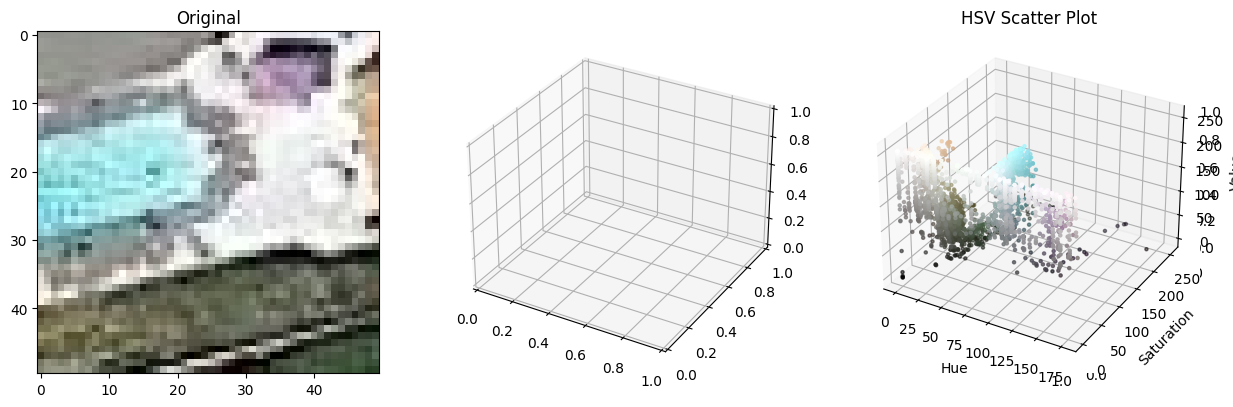

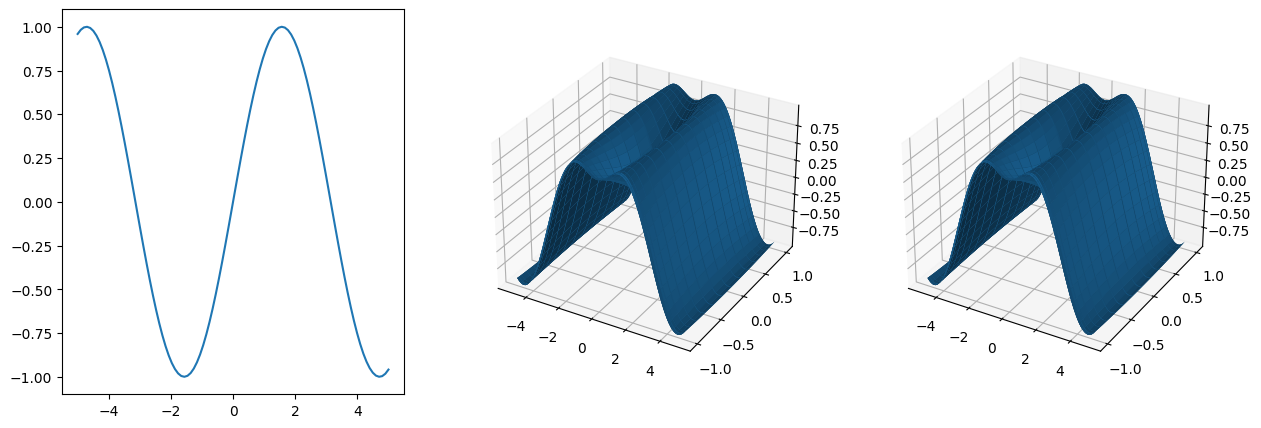

In [23]:

images = ['img16.jpg']


for image_name in images:
    imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', image_name))
    image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)

    # Create a new figure
    fig = plt.figure(figsize=(15, 5))

    # Create a 2D subplot
    ax1 = fig.add_subplot(1, 3, 1)

    # Create first 3D subplot
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')

    # Create second 3D subplot
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')

    ax1.imshow(image_rgb)
    ax1.set_title("Original")
    ax2 = fig.add_subplot(1, 3, 3, projection='3d')
    scatter_plot_hsv(image_rgb, ax2)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    scatter_plot_rgb(image_rgb, ax3)

# scatter_plot_rgb(image_rgb)
# image_hsv = scatter_plot_hsv(image_rgb)


# light_blue = (157, 200, 255)
# dark_blue = (0, 110, 255)

# pipe1 = pipeline()
# pipe1.add_operation(partial(kmeans_segmentation,k=5))
# kmeans = pipe1.apply(image_rgb, True)

# scatter_plot_rgb(kmeans)
# kmeans_hsv = scatter_plot_hsv(kmeans)

# lo_square = np.full((10, 10, 3), light_blue, dtype=np.uint8) / 255.0
# do_square = np.full((10, 10, 3), dark_blue, dtype=np.uint8) / 255.0

# plt.subplot(1, 2, 1)
# plt.imshow(do_square)
# plt.subplot(1, 2, 2)
# plt.imshow(lo_square)
# plt.show()

# plt.subplot(1, 2, 1)
# plt.imshow(colors.rgb_to_hsv(do_square))
# plt.subplot(1, 2, 2)
# plt.imshow(colors.rgb_to_hsv(lo_square))
# plt.show()

# mask = cv2.inRange(image_hsv, light_blue, dark_blue)
# result = cv2.bitwise_and(image_hsv, image_hsv, mask=mask)


# plt.subplot(1, 2, 1)
# plt.imshow(mask, cmap="gray")
# plt.subplot(1, 2, 2)
# plt.imshow(result)
# plt.show()


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate some example data
x = np.linspace(-5, 5, 100)
y = np.sin(x)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Create a new figure
fig = plt.figure(figsize=(15, 5))

# Create a 2D subplot
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x, y)

# Create first 3D subplot
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_surface(X, Y, Z)

# Create second 3D subplot
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot_surface(X, Y, Z)

plt.show()


### Segmentadores


In [ ]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img0.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

# pipe = pipeline()
# pipe.add_operation(keep_blue)
# binary = pipe.apply(imag, False)
# print_metrics(binary)
# display_image_mask(image_rgb, binary)
pipe1 = pipeline()
pipe1.add_operation(kmeans_segmentation)
#pipe.add_operation(to_grayscale)
pipe1.add_operation(otsu_threshold)
#pipe.add_operation(canny_edge_detection)
binary = pipe1.apply(imag, True)
display_image_mask(image_rgb, binary, title=pipe1)



pipe2 = pipeline()
pipe2.add_operation(kmeans_segmentation)
pipe2.add_operation(otsu_threshold)
pipe2.add_operation(morfology_cleaning)
binary = pipe2.apply(imag, False)
#print_metrics(binary)
display_image_mask(image_rgb, binary, title=pipe2)


pipe3 = pipeline()
pipe3.add_operation(otsu_threshold)
pipe3.add_operation(morfology_cleaning)
binary = pipe3.apply(imag, False)
print_metrics(binary)
display_image_mask(image_rgb, binary, title=pipe3)




imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img1566.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

pipe1 = pipeline()
pipe1.add_operation(kmeans_segmentation)
#pipe.add_operation(to_grayscale)
pipe1.add_operation(otsu_threshold)
#pipe.add_operation(canny_edge_detection)
binary = pipe1.apply(imag, True)
display_image_mask(image_rgb, binary)



pipe2 = pipeline()
pipe2.add_operation(partial(kmeans_segmentation, k=2))
pipe2.add_operation(otsu_threshold)
pipe2.add_operation(morfology_cleaning)
binary = pipe2.apply(imag, False)
#print_metrics(binary)
display_image_mask(image_rgb, binary)


pipe3 = pipeline()
pipe3.add_operation(otsu_threshold)
pipe3.add_operation(morfology_cleaning)
binary = pipe3.apply(imag, False)
print_metrics(binary)
display_image_mask(image_rgb, binary)

PIPELINE

COMENTARIO

In [ ]:
PIPELINE

COMENTARIO

EXPERIMENTO SOBRE TODAS LAS IMAGENES CON MASCARA PRE CALCULADA:

COMENTARIO

EXPERIMENTOS EXTRA/

generar mascaras con los varios segmentadores y hallar la interseccion de ellas, ver si mejora.

In [ ]:
DETERMINAR FORMA DE LA PISCINA/ EXTRAER CARACTERISTICAS, COMENTARLAS, FORMA, AREA, DEFINIR PRESICION ETC.



COMENTAR PROBLEMAS, DIFICULTADES, ETC (agregar ejemplos si vale la pena)